In [5]:
import scipy.io as sio
import numpy as np
import torch
import os
from os import listdir
from os.path import isfile, join
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np 
import math
import pandas as pd
import cmath
import scipy.io as sio
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import math
import pandas as pd
import cmath

#from unet import UNet
# from auto import encoder, decoder

from collections import OrderedDict
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
#==========================================================================
# For Plotting loss graph
# Bokeh
from bokeh.io import curdoc
from bokeh.layouts import column
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure

from functools import partial
from threading import Thread
from tornado import gen
# from AttRCNN_UNet import Att_R2U
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
import sys
# from dataloader import norm
import csv
from sklearn.model_selection import train_test_split
from sys import getsizeof
# import wandb
# import logging
# logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

In [6]:
nq_type = "SNS" # Sub-Nyquist or Nyquist sample
no_samples = 100
no_doa = 4

In [7]:
root_dataset_path =  ("../../SNS_dataset/100/DOA4")

In [40]:
def create_dataset(df, dataset_type):
  
    data = np.transpose(df[dataset_type], (2, 0, 1))
    label = df['DOA']
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.10, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [41]:
def get_data(train, label, batch_size, train_bool=True):
    class DOA_dataset(Dataset):
        def __init__(self, train, test):
            self.x = torch.from_numpy(np.array(train))
            self.y = torch.from_numpy(np.asarray(label))
            self.n_sample = len(self.y)
        def __getitem__(self, index):
            return self.x[index], self.y[index]
        def __len__(self):
            return self.n_sample


    dataset = DOA_dataset(train, label)
    

    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=train_bool)
    return loader

In [48]:
df1  = sio.loadmat("../SNS_dataset/100/DOA4/SNR_SNS_00_4.mat")
print(cmath.polar(df1['SNS_data'][0][0][0])[0])

0.07898742524722703


In [77]:
def create_dataloader(root_path, dataset_type, ss):
    # Loading all dataset 
    logging.info('Data prepration started')
#     df1  = sio.loadmat(root_path + "/SNR_{}_00_{}_{}.mat".format(nq_type, no_doa, no_samples))
#     df2  = sio.loadmat(root_path + "/SNR_{}_10_{}_{}.mat".format(nq_type, no_doa, no_samples))
#     df3  = sio.loadmat(root_path + "/SNR_{}_20_{}_{}.mat".format(nq_type, no_doa, no_samples))
#     df4  = sio.loadmat(root_path + "/SNR_{}_30_{}_{}.mat".format(nq_type, no_doa, no_samples))
#     df5  = sio.loadmat(root_path + "/SNR_{}_40_{}_{}.mat".format(nq_type, no_doa, no_samples))
    df1  = sio.loadmat("../SNS_dataset/100/DOA4/SNR_SNS_00_4.mat")
    df2  = sio.loadmat("../SNS_dataset/100/DOA4/SNR_SNS_10_4.mat")
    df3  = sio.loadmat("../SNS_dataset/100/DOA4/SNR_SNS_20_4.mat")
    df4  = sio.loadmat("../SNS_dataset/100/DOA4/SNR_SNS_30_4.mat")
    df5  = sio.loadmat("../SNS_dataset/100/DOA4/SNR_SNS_40_4.mat")
    df = [df1, df2, df3, df4, df5]

    new_train_dataset_list = []
    new_test_dataset_list = []
    train_dataset_list_label = []
    test_dataset_list_label = []

    dataset_len = 0
    if dataset_type == "SNS":
        dataset_len = ss//10
    if dataset_type == "NS":
        dataset_len = ss

    for file in df:
        X_train, X_test, y_train, y_test = create_dataset(file, dataset_type+"_data")
        new_train_dataset_list.extend(X_train)
        new_test_dataset_list.append(X_test.tolist())
        train_dataset_list_label.extend(y_train)
        test_dataset_list_label.append(y_test.tolist())

    # Deleteing all unused memory
    del df

    # Dividing into different channels
    logging.info('Dividing your dataset into 3 channel')

    for idx, data in enumerate(new_train_dataset_list):
        new = np.zeros((3, 8, dataset_len))
        for j in range(0, data.shape[0]):
            for k in range(0, data.shape[1]):
                new[0][j][k] = data[j][k].real
                new[1][j][k] = data[j][k].imag
                new[2][j][k] = cmath.phase(data[j][k])
        new_train_dataset_list[idx] = new

    for idx, data in enumerate(new_test_dataset_list):
        for i, ndata in enumerate(data):
            new = np.zeros((3, 8, dataset_len))
            for j in range(0, 8):
                for k in range(0, dataset_len):
                    new[0][j][k] = ndata[j][k].real
                    new[1][j][k] = ndata[j][k].imag
                    new[2][j][k] = cmath.phase(ndata[j][k])
            new_test_dataset_list[idx][i] = new

    # Generaring train loader
    logging.info('Creating Train dataloader')
    doa_train_loader = get_data(new_train_dataset_list, train_dataset_list_label, 64, True)

    # Deleteing all unused memory
    del new_train_dataset_list
    del train_dataset_list_label

    test_dataset_list = []
    logging.info('Creating Validation dataloader')
    for idx, data in enumerate(new_test_dataset_list):
        f = get_data(data, test_dataset_list_label[idx], 128, False)
        test_dataset_list.append(f)

    # Deleteing all unused memory
    del new_test_dataset_list
    del new
    logging.info('Your dataset is ready !!')
    return doa_train_loader ,test_dataset_list

In [78]:
doa_train_loader , test_dataset_list = create_dataloader(root_dataset_path, "SNS", 100)

2021-06-30 08:36:08,146 - Data prepration started
2021-06-30 08:36:12,266 - Dividing your dataset into 3 channel
2021-06-30 08:37:48,493 - Creating Train dataloader
2021-06-30 08:37:49,009 - Creating Validation dataloader
2021-06-30 08:37:49,106 - Your dataset is ready !!


In [60]:
class ConvAutoencoder(nn.Module):
    def __init__(self, img_ch=6,output_ch=1):
        super(ConvAutoencoder, self).__init__()
       
        #Encoder
        self.conv1 = nn.Conv2d(6, 64, 2, padding=1)  
        self.conv2 = nn.Conv2d(64, 128, 2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.linear = nn.Linear(25, 181)
        self.adp_pool = nn.AdaptiveMaxPool2d((no_doa, 25))    
        self.flat = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, stride=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.adp_pool(x)
        x = self.linear(x)
        x = self.flat(x)
        return x
if __name__ == "__main__":
#     print("start")
    image = torch.rand(1, 6, 8, 10)
    model = ConvAutoencoder()
    print(model(image).size())

torch.Size([1, 1, 4, 181])


In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=(3,3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu2(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=181):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=(1,3), stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=1)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=1)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=1)
        self.linear = nn.Linear(25, num_classes)
        self.adp_pool = nn.AdaptiveMaxPool2d((no_doa, 25))
        #self.flat = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1)
        self.flat = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1)
        self.dropout = nn.Dropout(0.9)
        self.dropout1 = nn.Dropout(0.8)
        self.relu = nn.ReLU(inplace=True)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.dropout(out)
        out = self.layer4(out)
        out = self.dropout1(out)
        out = self.adp_pool(out)
        out = self.linear(out)
        out = self.dropout1(out)
        out = self.flat(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [2, 3, 5, 2])

def ResNet1():
    return ResNet(BasicBlock, [1, 1, 1, 1])

def ResNet101():
    return ResNet(BasicBlock, [3, 4, 23, 3])


if __name__ == "__main__":
    image = torch.rand(1, 3, 10, 100)
    model = ResNet34()
    print(model(image).size())


torch.Size([1, 1, 4, 181])


In [ ]:
import torch
import torch.nn as nn
from torch.nn import init

def single_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True))
    return conv

def double_conv1(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=(3,2),padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=(3,2),stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True))
    return conv

def double_conv2(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=(3,3),padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=(3,3), padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True))
    return conv


def up_conv1(in_c, out_c):
    conv = nn.Sequential(
        nn.ConvTranspose2d(in_c, out_c, kernel_size=(2, 3), stride=2))
    return conv
    
def up_conv2(in_c, out_c):
    conv = nn.Sequential(
        nn.ConvTranspose2d(in_c, out_c, kernel_size=(2,2), stride=2))
    return conv


class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)
            
            x1 = self.conv(x+x1)
        return x1

class RRCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1


class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi



class Att_R2U(nn.Module):
    def __init__(self,img_ch=5,output_ch=5,t=2):
        super(Att_R2U, self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.RCNN1 = RRCNN_block(img_ch, 64, t=t)
        self.RCNN2 = RRCNN_block(64, 128, t=t)
        self.RCNN3 = RRCNN_block(128, 256, t=t)

        self.up_trans_1 = up_conv1(256, 128)
        self.Att1 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_RRCNN1 = RRCNN_block(256, 128,t=t)
        
        self.up_trans_2 = up_conv2(128, 64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_RRCNN2 = RRCNN_block(128, 64,t=t)
        self.dropout = nn.Dropout(p=0.3)
        self.out = nn.Conv2d(
            in_channels=64,
            out_channels=output_ch,
            kernel_size=1,stride=1,padding=0)

    def forward(self, image):
        # encoder
        # print("Input Image            => ", image.size())
        # print("Encoder =================")
        x1 = self.RCNN1(image)
        # print("Conv3x2, S1, P1        => ", x1.size())
        x2 = self.max_pool_2x2(x1)
        # print("max_pool_2x1           => ", x2.size())
        x3 = self.RCNN2(x2)
        x3 = self.dropout(x3)
        # print("Conv3x3, S1, P1        => ", x3.size())
        x4 = self.max_pool_2x2(x3)
        # print("max_pool_2x1           => ", x4.size())
        x5 = self.RCNN3(x4)
        x5 = self.dropout(x5)
        # print("Conv3x3, S1, P1        => ", x5.size())
        
        
        # decoder
        # print("Decoder =================")
        x = self.up_trans_1(x5)
        # print("up_trans_1x18, S3, P0  => ", x.size())
        x3 = nn.functional.interpolate(x3, (x.size()[2], x.size()[3]))
        x3 = self.Att1(g=x,x=x3)
        x = self.Up_RRCNN1(torch.cat([x, x3], 1))
        x = self.dropout(x)
        # print("up_conv_3x3, S1, P1    => ", x.size())

        x = self.up_trans_2(x)
        # print("up_trans_2x2, S2, P0   => ", x.size())
        x1 = nn.functional.interpolate(x1, (x.size()[2], x.size()[3]))
        x1 = self.Att2(g=x,x=x1)
        x = self.Up_RRCNN2(torch.cat([x, x1], 1))
        x = self.dropout(x)
        # print("up_conv_2x3, s1, p1    => ", x.size())
        # output
        x = self.out(x)
#         print(x.size())
        return x



if __name__ == "__main__":
#     print("start")
    image = torch.rand(1, 3, 8, 10)
    model = Att_R2U()
    print(model(image).size())

In [80]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [ ]:
#pre trained unet
# pre_trained = torch.load("./doa_weights/SNS_DOA_1_Unet_model.pth")
# for prams in pre_trained.parameters():
#     prams.requires_grad = False
pre_trined = Att_R2U()

In [1]:
num_epochs = 70

weights_dir = "./doa_weights"

autoencoder = ResNet34()
cross_criterion = nn.CrossEntropyLoss()
focal_criterion = FocalLoss()
# if ('{}_DOA_{}_{}_model.pth'.format(nq_type, no_doa, no_samples) in [f for f in listdir(weights_dir) if isfile(join(weights_dir, f))]):
#     print("Pre-trained available for DOA_{}_{}_model.pth".format(no_doa, no_samples))
#     autoencoder = torch.load(os.path.join(weights_dir, '{}_DOA_{}_{}_model.pth'.format(nq_type, no_doa, no_samples)))

# model = nn.Sequential( pre_trained, autoencoder)
# model = ConvAutoencoder()
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    classification_model = autoencoder.cuda()
    optimizer = optim.AdamW(classification_model.parameters(), lr=0.001, weight_decay=1e-3)
  
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", factor=0.05, patience=3, verbose=True)

NameError: name 'ResNet34' is not defined

In [96]:
acc_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}
loss_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}
mae_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}

In [97]:
%%time
def train():
    print("Training Starts !!!!!!!")
    best_valid_loss = float('Inf')
    for i in range(num_epochs):
        training_loss = 0
        train_correct = 0
        train_total = 0
        epoch_loss = 0.0
        training_mae = 0.0
        classification_model.train()
        criterion = None
        if (i+1)>=25 :
          print("Criterion is changed to focal loss")
          criterion = focal_criterion.cuda()
        else:
          criterion = cross_criterion.cuda()
        for j,(features, labels) in enumerate(doa_train_loader, 0):
            features, labels = Variable(features.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()
            enn = classification_model(features.float())
            auto_outputs = torch.transpose(enn, 2, 3)
            auto_outputs = torch.reshape(auto_outputs.cuda(), (auto_outputs.shape[0], 181, no_doa))
            losss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())
            losss.backward()
            optimizer.step()
#           exp_scheduler.step()
            training_loss += losss.item()

            _, pred = torch.max(auto_outputs, 1)

            train_total+= labels.reshape(-1).size(0)

            train_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()

            epoch_loss += auto_outputs.shape[0] * losss.item()
            training_mae += torch.mean(torch.abs(pred.float().cuda() - labels.float()))

        loss_res['training'].append(training_loss/len(doa_train_loader))
        acc_res['training'].append((100*(train_correct/train_total)))
        mae_res['training'].append(training_mae/(len(doa_train_loader)*181))
        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.4f}, Training MAE: {}'
                      .format(i+1, num_epochs, training_loss/len(doa_train_loader), (100*(train_correct/train_total)), training_mae/(len(doa_train_loader)*181)))
        
        # Validation for each SNR value
        classification_model.eval()
        total_valdation_loss = 0
        zero_val = 0
        for val_data in range(0, len(test_dataset_list)):
            
            validation_loss = 0
            validation_acc = 0
            validation_mae = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for features, labels in test_dataset_list[val_data]:
                    features, labels = Variable(features.cuda()), Variable(labels.cuda())
                    enn = classification_model(features.float())
                    auto_outputs = torch.transpose(enn, 2, 3)
                    auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, no_doa))
                    loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

                    _, pred = torch.max(auto_outputs, 1)
                    val_total+= labels.reshape(-1).size(0)
                    val_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                    validation_loss += loss.item()
                    validation_mae += torch.mean(torch.abs(pred.float().cuda() - labels.float()))

                loss_res[10*val_data].append(validation_loss/len(test_dataset_list[val_data]))
                acc_res[10*val_data].append((100*(val_correct/val_total)))
                
                mae_res[10*val_data].append(validation_mae/(len(test_dataset_list[val_data])*181))
                print('SNR [{}dB], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}, Validation MAE: {}'
                      .format(val_data*10, validation_loss/len(test_dataset_list[val_data]), (100*(val_correct/val_total)), validation_mae/(len(test_dataset_list[val_data])*181)))

                total_valdation_loss+=validation_loss

        scheduler.step(loss_res[0][len(loss_res[0])-1])
        # print("Odb Loss => ", loss_res[0][len(loss_res[0])-1])
        # print("Lr -> ", optimizer.state_dict()["param_groups"][0]['lr'])
        torch.save( classification_model, weights_dir+ "/{}_DOA_{}_{}_model.pth".format(nq_type, no_doa, no_samples))
        if best_valid_loss > total_valdation_loss:
            best_valid_loss = total_valdation_loss 
            # Saving Best Pre-Trained Model as .pth file
            torch.save( classification_model, weights_dir+ "/{}_DOA_{}_{}_best_model.pth".format(nq_type, no_doa, no_samples))
#         if i%10 == 0:
#           ddf = pd.DataFrame(acc_res)
#           ddf.to_csv(weights_dir+"res_DOA_{}_model.csv".format(doa))
        print("\n")

train()
print("Training Complete")

Training Starts !!!!!!!
Epoch [1/70], Training Loss: 3.8098, Training Accuracy: 8.7899, Training MAE: 0.15840837359428406
SNR [0dB], Validation Loss: 4.3791, Validation Accuracy: 4.8200, Validation MAE: 0.20209960639476776
SNR [10dB], Validation Loss: 3.1129, Validation Accuracy: 14.9400, Validation MAE: 0.06338689476251602
SNR [20dB], Validation Loss: 2.5908, Validation Accuracy: 22.0975, Validation MAE: 0.027193499729037285
SNR [30dB], Validation Loss: 2.4679, Validation Accuracy: 24.6525, Validation MAE: 0.020755385980010033
SNR [40dB], Validation Loss: 2.4492, Validation Accuracy: 25.1200, Validation MAE: 0.01956498809158802


Epoch [2/70], Training Loss: 2.4441, Training Accuracy: 24.1138, Training MAE: 0.04654095694422722
SNR [0dB], Validation Loss: 4.1866, Validation Accuracy: 6.7075, Validation MAE: 0.16443294286727905
SNR [10dB], Validation Loss: 2.9571, Validation Accuracy: 20.5750, Validation MAE: 0.052870012819767
SNR [20dB], Validation Loss: 2.1749, Validation Accuracy: 35

KeyboardInterrupt: 

In [100]:
# SNS DOA-2 200 Samples
print("=== Metrics ===")
print("==== DOA-{} ====".format(no_doa))
print("= MAE =_= Acc =")
print("{:.4f}".format(min(mae_res[0])), "  {:.2f}".format(acc_res[0][mae_res[0].index(min(mae_res[0]))]))
print("{:.4f}".format(min(mae_res[10])), "  {:.2f}".format(acc_res[10][mae_res[10].index(min(mae_res[10]))]))
print("{:.4f}".format(min(mae_res[20])), "  {:.2f}".format(acc_res[20][mae_res[20].index(min(mae_res[20]))]))
print("{:.4f}".format(min(mae_res[30])), "  {:.2f}".format(acc_res[30][mae_res[30].index(min(mae_res[30]))]))
print("{:.4f}".format(min(mae_res[40])), "  {:.2f}".format(acc_res[40][mae_res[40].index(min(mae_res[40]))]))

=== Metrics ===
==== DOA-4 ====
= MAE =_= Acc =
0.1089   8.07
0.0384   24.09
0.0154   49.16
0.0073   73.73
0.0046   84.80


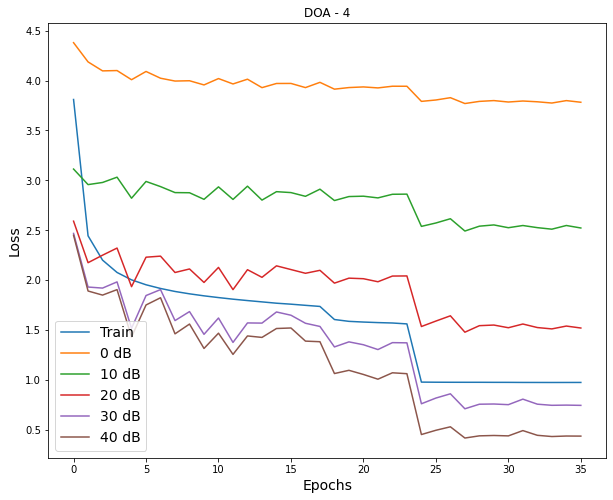

In [101]:
import matplotlib.pyplot as plt
ep = range(0, len(loss_res["training"]))
plt.figure(figsize=(10, 8))
plt.plot(ep, loss_res["training"], label='Train')
plt.plot(ep, loss_res[0], label='0 dB')
plt.plot(ep, loss_res[10], label='10 dB')
plt.plot(ep, loss_res[20], label='20 dB')
plt.plot(ep, loss_res[30], label='30 dB')
plt.plot(ep, loss_res[40], label='40 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("DOA - {}".format(no_doa))
plt.legend(fontsize=14)
plt.show()